# Program Description
## Target
We compares the forecast performance of the time series model and the neural network model in BDI and Kilian index. In this example, we performs the forecast of Kilian Index.
## Time Range (from Jan. 1990 to Aug. 2022)
We collected data from FRED and Eikon including Datastream in our research purpose. Since some of the data may have copyright issue, we don't provide the whole original data.

# Import Packages

In [1]:
import datetime
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from tabulate import tabulate
import tensorflow as tf
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp

# Import Data

In [52]:
all_xlsx = pd.ExcelFile(r'kilian_forecast.xlsx')
all_df = all_xlsx.parse('all').set_index(['date'])

## Descriptive statistics

In [53]:
all_df.describe()

,kilian_index,unrate,usgdpnormal,eugdpnormal,usconsumerconfidence,euconsumerconfidence,usworkertransportwarehouse,wti,ironores,SP500_index,MSCI World Index
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,2.945694,5.852041,99.891643,1.574033,100.036247,99.913538,4459.114286,49.191212,119.995265,1479.401904,1302.123441
std,60.966239,1.727644,1.106363,2.609858,1.517341,1.473588,713.656102,29.369708,30.881915,973.859075,618.333163
min,-162.968510,3.500000,91.729968,-14.587528,96.050136,95.279481,3444.000000,11.280000,82.500000,307.124783,454.793500
25%,-36.578176,4.600000,99.521088,1.044037,99.001848,99.040171,4109.225000,21.688000,95.000000,876.936242,835.336212
50%,-6.069596,5.500000,99.917549,1.902367,100.398963,100.020542,4335.000000,44.685000,120.050000,1243.255721,1204.469441
75%,32.752081,6.725000,100.453376,2.837817,101.069189,101.006581,4640.875000,70.797500,141.125000,1907.584286,1653.057436
max,188.204050,14.700000,101.841163,14.404877,102.894911,102.469233,6712.100000,133.930000,214.199000,4676.990870,3202.827727


In [54]:
all_df.corr(method='pearson')

,kilian_index,unrate,usgdpnormal,eugdpnormal,usconsumerconfidence,euconsumerconfidence,usworkertransportwarehouse,wti,ironores,SP500_index,MSCI World Index
kilian_index,1.000000,-0.016284,0.229030,0.189512,-0.238505,-0.084067,-0.057023,0.259915,0.055269,-0.076696,-0.014498
unrate,-0.016284,1.000000,-0.637576,-0.582937,-0.602463,-0.599196,-0.321569,0.205169,0.173521,-0.271118,-0.272823
usgdpnormal,0.229030,-0.637576,1.000000,0.666772,0.335474,0.411768,-0.002433,0.174108,-0.047046,-0.024265,0.058992
eugdpnormal,0.189512,-0.582937,0.666772,1.000000,0.320109,0.551281,0.026199,-0.057650,-0.142116,0.056552,0.076283
usconsumerconfidence,-0.238505,-0.602463,0.335474,0.320109,1.000000,0.689486,-0.069424,-0.556528,-0.509365,-0.067179,-0.064491
euconsumerconfidence,-0.084067,-0.599196,0.411768,0.551281,0.689486,1.000000,0.069807,-0.392908,-0.328894,0.102818,0.117448
usworkertransportwarehouse,-0.057023,-0.321569,-0.002433,0.026199,-0.069424,0.069807,1.000000,0.469524,0.741041,0.979765,0.971046
wti,0.259915,0.205169,0.174108,-0.057650,-0.556528,-0.392908,0.469524,1.000000,0.810729,0.448049,0.532373
ironores,0.055269,0.173521,-0.047046,-0.142116,-0.509365,-0.328894,0.741041,0.810729,1.000000,0.718403,0.751381
SP500_index,-0.076696,-0.271118,-0.024265,0.056552,-0.067179,0.102818,0.979765,0.448049,0.718403,1.000000,0.986976


# Stationarity

## ADF Test

In [55]:
# Output of ADF test
columns = all_df.columns
cadfs = [ts.adfuller(all_df[column]) for column in columns]
for i in range(all_df.shape[1]):
    cadfs[i] = list(cadfs[i])
for i in range(len(cadfs)):
    cadfs[i].insert(0, all_df.columns[i])

print(tabulate(cadfs, headers=['Variables', 'ADF Statistic', 'p-value', 'lags', 'obs', 'Critical Values', 'MIC']))

Variables                     ADF Statistic      p-value    lags    obs  Critical Values                                                                          MIC
--------------------------  ---------------  -----------  ------  -----  ----------------------------------------------------------------------------------  --------
kilian_index                     -2.96887    0.0379057        11    380  {'1%': -3.4476763783532585, '5%': -2.869176103659426, '10%': -2.570837873961219}    3212.73
unrate                           -3.21159    0.0193235         0    391  {'1%': -3.4471856790801514, '5%': -2.868960436182993, '10%': -2.5707229006220524}    655.267
usgdpnormal                      -4.86081    4.15468e-05       4    387  {'1%': -3.447360865754795, '5%': -2.8690374364690445, '10%': -2.5707639493486636}     17.71
eugdpnormal                      -3.85969    0.0023524        15    376  {'1%': -3.4478619826418817, '5%': -2.869257669826291, '10%': -2.570881358363513}     884.309
uscons

## Data Transformation

In [56]:
# from the table above, we can see that some variables are not stationary
# dataframe keep only the variables that are stationary
st_df =  all_df[['kilian_index', 'unrate', 'usgdpnormal', 'eugdpnormal', 'euconsumerconfidence']]
# dataframe only the variables that are not stationary
nost_df = all_df[['usconsumerconfidence', 'usworkertransportwarehouse', 'wti', 'ironores', 'SP500_index', 'MSCI World Index']]

In [57]:
# dataframe of the first difference of the variables that are not stationary
diff_df = nost_df.diff().dropna()

In [58]:
# Output of ADF test
columns = diff_df.columns
cadfs = [ts.adfuller(diff_df[column]) for column in columns]
for i in range(diff_df.shape[1]):
    cadfs[i] = list(cadfs[i])
for i in range(len(cadfs)):
    cadfs[i].insert(0, diff_df.columns[i])

print(tabulate(cadfs, headers=['Variables', 'ADF Statistic', 'p-value', 'lags', 'obs', 'Critical Values', 'MIC']))

Variables                     ADF Statistic      p-value    lags    obs  Critical Values                                                                          MIC
--------------------------  ---------------  -----------  ------  -----  ----------------------------------------------------------------------------------  --------
usconsumerconfidence               -8.28898  4.31301e-13       4    386  {'1%': -3.447405233596701, '5%': -2.8690569369014605, '10%': -2.5707743450830893}   -569.351
usworkertransportwarehouse        -12.3208   6.75845e-23       1    389  {'1%': -3.447272819026727, '5%': -2.868998737588248, '10%': -2.5707433189709294}    3745.65
wti                                -9.38757  6.69493e-16       5    385  {'1%': -3.4474498334928687, '5%': -2.8690765390453703, '10%': -2.570784795075055}   2212.03
ironores                          -12.2267   1.07666e-22       2    388  {'1%': -3.4473167281607155, '5%': -2.869018036958473, '10%': -2.5707536074503134}   2114.61
SP500_i

In [59]:
st_df = st_df.join(diff_df, how='outer').dropna()

# Time Series Models Forecasting

# Time Series Description (ACFs, PACFs)

Here, we provide the examples of Kilian Index and WTI.

## Kilian Index

<AxesSubplot: xlabel='date'>

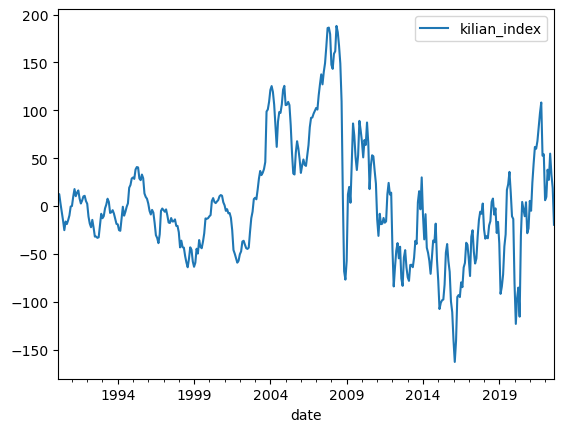

In [125]:
# Plot Kilian Index time series
st_df[['kilian_index']].plot()

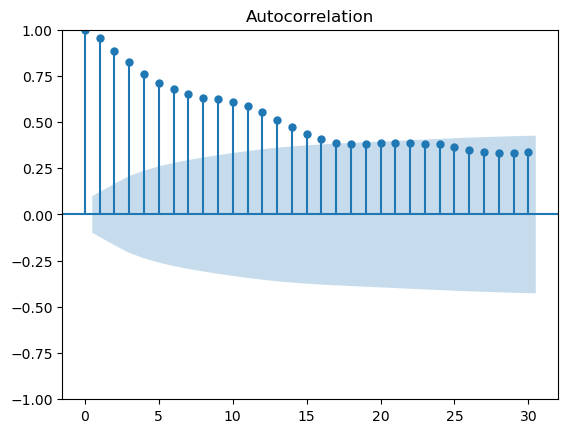

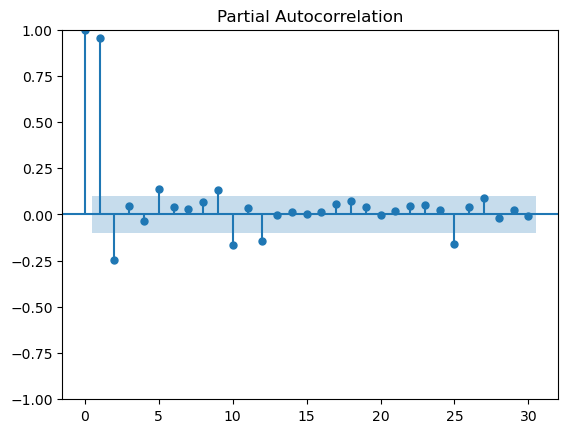

In [60]:
sm.graphics.tsa.plot_acf(st_df['kilian_index'], lags=30);
sm.graphics.tsa.plot_pacf(st_df['kilian_index'], lags=30, method='ywm');

## WTI (Oil Price)

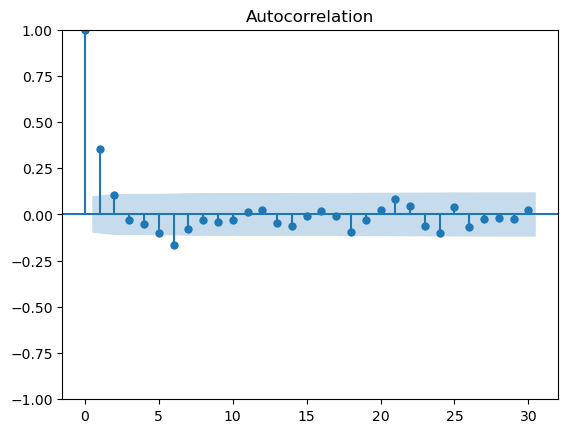

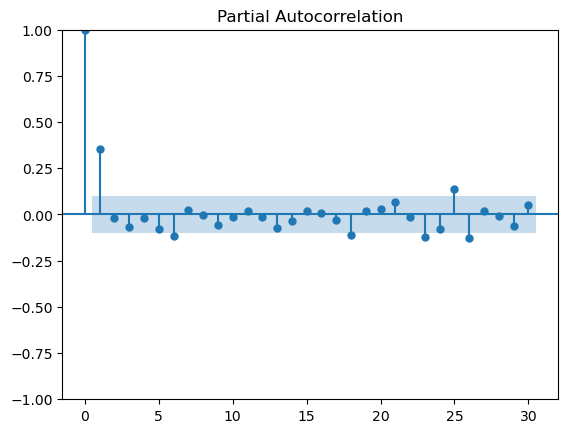

In [61]:
sm.graphics.tsa.plot_acf(st_df['wti'], lags=30);
sm.graphics.tsa.plot_pacf(st_df['wti'], lags=30, method='ywm');

# Data Split

In [105]:
# Train, test split
# nobs --> number of forecast periods
nobs = 42
train_df = st_df[:-nobs]
test_df = st_df[-nobs:]

# Time Series Models Forecasting by Grid Search Method

In [64]:
# Create a list of the orders to be tested, by the ACFs and PACFs of the variables, we set the range of the orders as below
# p = number of autoregressive terms
# q = number of moving average terms
# d = number of differences
p = q = d = range(0,10)
pqd = list(itertools.product(p, q, d))
for i in pqd:
    if i[-1] == 1:
        pqd.remove(i)
for i in pqd:
    if i[-1] == 2:
        pqd.remove(i)
for i in pqd:
    if i[-1] == 3:
        pqd.remove(i)
for i in pqd:
    if i[-1] == 4:
        pqd.remove(i)
for i in pqd:
    if i[-1] == 5:
        pqd.remove(i)
for i in pqd:
    if i[-1] == 6:
        pqd.remove(i)
for i in pqd:
    if i[-1] == 7:
        pqd.remove(i)
for i in pqd:
    if i[-1] == 8:
        pqd.remove(i)
for i in pqd:
    if i[-1] == 9:
        pqd.remove(i)

## Univariate

### Grid Search

In [ ]:
aic_all_list = []
for order in pqd:
    model = sm.tsa.ARIMA(endog=train_df[['kilian_index']], order=order)
    result = model.fit()
    aic_all = result.aic
    aic_all_list.append(aic_all)
    print('ARIMA{} - AIC All:{}'.format(order, aic_all))

In [66]:
print('Best order by AIC:', pqd[aic_all_list.index(np.min(aic_all_list))])

Best order by AIC: (9, 1, 0)


### Forecasting

In [ ]:
model = sm.tsa.ARIMA(train_df[['kilian_index']], order=[9,1,0], enforce_stationarity=False)
result = model.fit()
fore_df = result.forecast(steps=nobs)

In [72]:
# Evaluation of the model
print('MSE:', sum((np.array(test_df['kilian_index']) - np.array(fore_df))**2))

MSE: 384302.28668759856


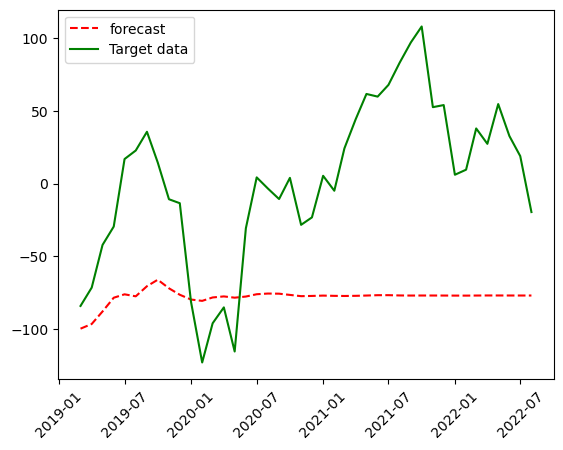

In [73]:
# Plot the results
plt.plot(test_df.index, fore_df, color='r', linestyle='--', label='forecast')
plt.plot(test_df.index, test_df['kilian_index'], color='g', linestyle='-', label='Target data')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Multivariate (Factual)

### Grid Search

In [ ]:
# Using actual data to predict
aic_all_list = []
for order in pqd:
    model = sm.tsa.ARIMA(endog=train_df[['kilian_index']], 
                         exog=train_df[['unrate', 'usgdpnormal', 'eugdpnormal',
                                        'euconsumerconfidence', 'usconsumerconfidence',
                                        'usworkertransportwarehouse', 'wti', 'ironores', 
                                        'SP500_index', 'MSCI World Index']])
    result = model.fit()
    aic_all = result.aic
    aic_all_list.append(aic_all)
    print('ARIMA{} - AIC All:{}'.format(order, aic_all))

In [68]:
print('Best order by AIC:', pqd[aic_all_list.index(np.min(aic_all_list))])

Best order by AIC: (9, 1, 0)


### Forecasting

In [ ]:
model = sm.tsa.ARIMA(endog=train_df[['kilian_index']],
                     exog=train_df[['unrate', 'usgdpnormal', 'eugdpnormal',
                                    'euconsumerconfidence', 'usconsumerconfidence',
                                    'usworkertransportwarehouse', 'wti', 'ironores']],
                     order=[9,1,0]
                     )
result = model.fit()

In [77]:
fore_df = result.forecast(steps=nobs, 
                          exog=test_df[['unrate', 'usgdpnormal', 'eugdpnormal',
                                        'euconsumerconfidence', 'usconsumerconfidence',
                                        'usworkertransportwarehouse', 'wti', 'ironores']])

In [78]:
sum((test_df['kilian_index'] - fore_df)**2)

496790.9936754208

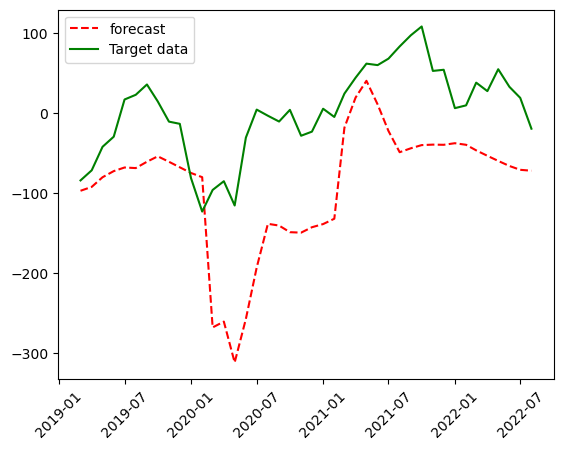

In [79]:
plt.plot(test_df.index, fore_df, color='r', linestyle='--', label='forecast')
plt.plot(test_df.index, test_df['kilian_index'], color='g', linestyle='-', label='Target data')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Multivariate (Predicted)

### Forecasting

In [ ]:
# Exogenous Variables have been grid searched and the best orders
# unrate
model = sm.tsa.ARIMA(train_df[['unrate']], order=[7,0,0])
result = model.fit()
fore_df_unrate = result.forecast(steps=nobs)
# usgdpnormal
model = sm.tsa.ARIMA(train_df[['usgdpnormal']], order=[8,0,0])
result = model.fit()
fore_df_usgdpnormal = result.forecast(steps=nobs)
# eugdpnormal
model = sm.tsa.ARIMA(train_df[['eugdpnormal']], order=[7,0,0])
result = model.fit()
fore_df_eugdpnormal = result.forecast(steps=nobs)
# euconsumerconfidence
model = sm.tsa.ARIMA(train_df[['euconsumerconfidence']], order=[9,0,0])
result = model.fit()
fore_df_euconsumerconfidence = result.forecast(steps=nobs)
# usconsumerconfidence
model = sm.tsa.ARIMA(train_df[['usconsumerconfidence']], order=[7,0,0])
result = model.fit()
fore_df_usconsumerconfidence = result.forecast(steps=nobs)
# usworkertransportwarehouse
model = sm.tsa.ARIMA(train_df[['usworkertransportwarehouse']], order=[9,1,0])
result = model.fit()
fore_df_usworkertransportwarehouse = result.forecast(steps=nobs)
# wti
model = sm.tsa.ARIMA(train_df[['wti']], order=[9,0,0])
result = model.fit()
fore_df_wti = result.forecast(steps=nobs)
# ironores
model = sm.tsa.ARIMA(train_df[['ironores']], order=[9,0,0])
result = model.fit()
fore_df_ironores = result.forecast(steps=nobs)
# SP500_index
model = sm.tsa.ARIMA(train_df[['SP500_index']], order=[9,0,0])
result = model.fit()
fore_df_SP500_index = result.forecast(steps=nobs)
# MSCI World Index
model = sm.tsa.ARIMA(train_df[['MSCI World Index']], order=[9,0,0])
result = model.fit()
fore_df_MSCI = result.forecast(steps=nobs)
#
fore_exog = np.array([fore_df_unrate, fore_df_usgdpnormal, fore_df_eugdpnormal, fore_df_euconsumerconfidence, 
                      fore_df_usconsumerconfidence, fore_df_usworkertransportwarehouse, fore_df_wti,
                      fore_df_ironores, fore_df_SP500_index, fore_df_MSCI]
                      )
model = sm.tsa.ARIMA(endog=train_df[['kilian_index']],
                     exog=train_df[['unrate', 'usgdpnormal', 'eugdpnormal',
                                    'euconsumerconfidence', 'usconsumerconfidence',
                                    'usworkertransportwarehouse', 'wti', 'ironores',
                                    'SP500_index', 'MSCI World Index']],
                     order=[9,1,0]
                     )
result = model.fit()
fore_df = result.forecast(steps=nobs, exog=fore_exog.transpose())

In [81]:
print('MSE:', sum((test_df['kilian_index'] - fore_df)**2))

MSE: 304727.0332175229


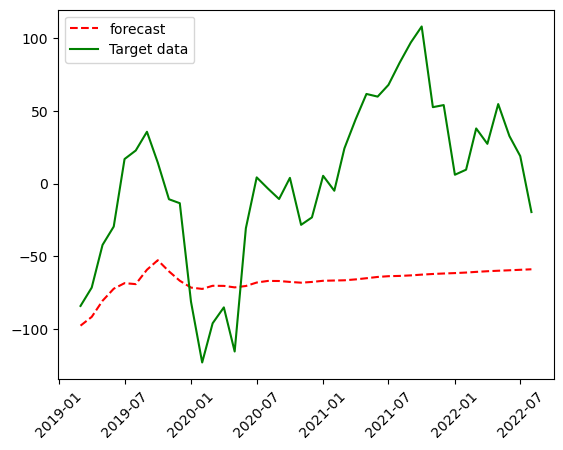

In [82]:
plt.plot(test_df.index, fore_df, color='r', linestyle='--', label='forecast')
plt.plot(test_df.index, test_df['kilian_index'], color='g', linestyle='-', label='Target data')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## VAR Forecasting

In [ ]:
aic_all_list = []
lag_order_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for order in lag_order_list:
    model = sm.tsa.VAR(train_df[:-nobs])
    result = model.fit(order)
    aic_all = result.aic
    aic_all_list.append(aic_all)
    print('VAR({}) - AIC All:{}'.format(order, aic_all))

In [70]:
lag_order_list[aic_all_list.index(np.min(aic_all_list))]

9

In [ ]:
model = sm.tsa.VAR(train_df[['kilian_index', 'unrate', 'usgdpnormal', 'eugdpnormal',
                             'euconsumerconfidence', 'usconsumerconfidence',
                             'usworkertransportwarehouse', 'wti', 'ironores']])
result = model.fit(9)
lag_order = result.k_ar

In [84]:
forecast_input = train_df[['kilian_index', 'unrate', 'usgdpnormal', 'eugdpnormal',
                           'euconsumerconfidence', 'usconsumerconfidence',
                           'usworkertransportwarehouse', 'wti', 'ironores']
                          ].values[-lag_order:]


In [85]:
fc = result.forecast(y=forecast_input, steps=nobs)
var_forecast = pd.DataFrame(fc, index=test_df.index,
                            columns=train_df[['kilian_index', 'unrate', 'usgdpnormal', 'eugdpnormal',
                                              'euconsumerconfidence', 'usconsumerconfidence',
                                              'usworkertransportwarehouse', 'wti', 'ironores']].columns)


In [86]:
# MSE
print(sum((test_df['kilian_index'] - var_forecast['kilian_index'])**2))

145065.85609221162


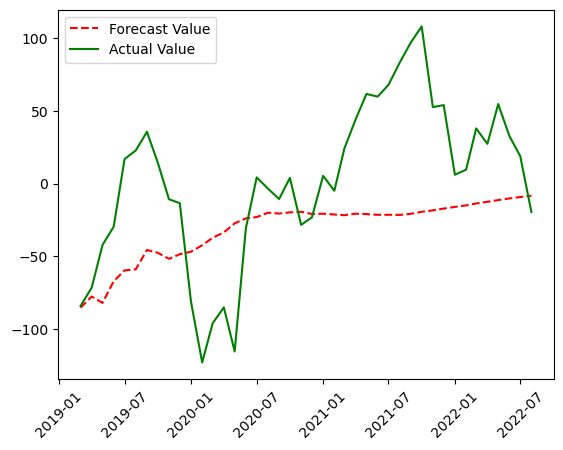

In [87]:
plt.plot(test_df.index, var_forecast['kilian_index'], color='r', linestyle='--', label='Forecast Value')
plt.plot(test_df.index, test_df['kilian_index'], color='g', linestyle='-', label='Actual Value')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Neural Network Models Forecasting

RNN and LSTM are same in the following RNN examples

## Data Split

In [108]:
# Train, validation, test split for NN model training

# n_steps --> number of lags to predict future
# nobs --> number of forecast periods
# n_valid --> validation set
# n --> total number of observations
# d --> number of features
# shape(Sample size) = (sample size, time steps, features)
n_steps = 45
nobs = 42
n_valid = 50
n = st_df.shape[0]
d = st_df.shape[1]
n_train = n - nobs - n_valid

test = st_df[-nobs-n_steps:]
valid = st_df[-n_steps-n_valid-nobs:-nobs]
train = st_df[:n_train]

# Split train set into subsequences
X_train = np.empty((n_train - n_steps - nobs, n_steps, d))
Y_train = np.empty((n_train - n_steps - nobs, n_steps, nobs))
for i in range(n_train - n_steps - nobs):
    X_train[i, :, :] = train[i : i+n_steps]
    for j in range(nobs):
        Y_train[i, :, j] = train[i+j+1 : i+j+n_steps+1].iloc[:,0]

# Split validation set into subsequences
X_valid = np.empty((n_valid - nobs, n_steps, d))
Y_valid = np.empty((n_valid - nobs, n_steps, nobs))
for i in range(n_valid - nobs):
    X_valid[i, :, :] = valid[i : i+n_steps]
    for j in range(nobs):
        Y_valid[i, :, j] = valid[i+j+1 : i+j+n_steps+1].iloc[:,0]

# Split test set into subsequences
X_test = np.array(st_df[-nobs-n_steps:-nobs])
Y_test = np.empty((n_steps, nobs))
for j in range(nobs):
    Y_test[:, j] = test[j+1 : j+n_steps+1].iloc[:,0]

X_test = X_test.reshape(1, n_steps, d)
Y_test = Y_test.reshape(1, n_steps, nobs)

# Normalization
X_min = X_train.min(axis=(0, 1), keepdims=True)
X_max = X_train.max(axis=(0, 1), keepdims=True)
X_train_norm = (X_train - X_min)/(X_max - X_min)

Y_min = Y_train.min(axis=(0, 1), keepdims=True)
Y_max = Y_train.max(axis=(0, 1), keepdims=True)
Y_train_norm = (Y_train - Y_min)/(Y_max - Y_min)

X_valid_norm = (X_valid - X_min)/(X_max - X_min)
Y_valid_norm = (Y_valid - Y_valid)/(Y_max - Y_min)

In [109]:
# Train, test split

train_df = st_df[:-nobs]
test_df = st_df[-nobs:]

## Hyperparameter Tuning

In [ ]:
# Create parameters combinations (Remind: beaware of the computation power)
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([8, 16, 64, 128, 256, 512, 1024, 1536, 2048, 3072, 4096]))
#HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([]))
#HP_NUM_LAYERS = hp.HParam('num_layers', hp.Discrete([0, 1, 2]))
HP_NUM_LAYERS = hp.HParam('num_layers', hp.Discrete([0]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.1]))
#HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))
#HP_LEARNING_RATE= hp.HParam('learning_rate', hp.Discrete([0.03, 0.003]))
HP_LEARNING_RATE= hp.HParam('learning_rate', hp.Discrete([0.003, 0.0003]))

METRIC_ACCURACY = 'mean_squared_error'

METRICS = [hp.Metric(
            "epoch_loss",
            group="validation",
            display_name="loss (val.)",
           ),
           hp.Metric(
            "epoch_loss",
            group="train",
            display_name="loss (train)",
           ),
           hp.Metric(
            'mean_squared_error',
            display_name='MSE',
           )
          ]

with tf.summary.create_file_writer('model_kilian/rnn/logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_NUM_LAYERS, HP_DROPOUT, HP_LEARNING_RATE],
    metrics=METRICS,
  )

In [ ]:
#tensorboard log file
log_dir ='model_kilian/rnn/logs' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
with tf.summary.create_file_writer(log_dir).as_default():
   hp.hparams_config(hparams=[HP_NUM_UNITS, HP_NUM_LAYERS, HP_DROPOUT, HP_LEARNING_RATE],
                     metrics=METRICS,
                     )

In [ ]:
# model archetechture
def build_rnn_model(hparams, input_shape=[None,12]):
    model = keras.models.Sequential(name='SimpleRNN')
    model.add(keras.layers.SimpleRNN(hparams[HP_NUM_UNITS], return_sequences = True, activation='sigmoid', input_shape=input_shape))
    for layer in range(hparams[HP_NUM_LAYERS]):
        model.add(keras.layers.SimpleRNN(hparams[HP_NUM_UNITS], return_sequences=True, activation='sigmoid', input_shape=input_shape))
    model.add(keras.layers.Dropout(hparams[HP_DROPOUT]))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(nobs)))
    learning_rate = hparams[HP_LEARNING_RATE]
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

    # Comiple the model
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mean_squared_error'])
    callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor="mean_squared_error", patience=10),
                      tf.keras.callbacks.TensorBoard(log_dir), # log metrics
                      hp.KerasCallback(log_dir, hparams),]
    model.fit(X_train_norm, Y_train_norm, epochs=300,
              validation_data=(X_valid_norm, Y_valid_norm), 
              callbacks=callbacks_list
              )
    _, accuracy = model.evaluate(X_test, Y_test)
    return accuracy

In [ ]:
# run the model in each parameter combination
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        # recording the parameters used
        hp.hparams(hparams)
        accuracy = build_rnn_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
# start the training
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
    for num_layers in HP_NUM_LAYERS.domain.values:
        for dropout_rate in HP_DROPOUT.domain.values:
            for learning_rate in HP_LEARNING_RATE.domain.values:
                hparams = {
                    HP_NUM_UNITS: num_units,
                    HP_NUM_LAYERS: num_layers,
                    HP_DROPOUT: dropout_rate,
                    HP_LEARNING_RATE: learning_rate
                }
                run_name = "run-%d" % session_num
                print('--- Starting trial: %s' % run_name)
                print({h.name: hparams[h] for h in hparams})
                run('model_kilian/rnn/logs/hparam_tuning/' + run_name, hparams)
                # tensorboard log file
                log_dir ='model_kilian/rnn/logs/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
                with tf.summary.create_file_writer(log_dir).as_default():
                    hp.hparams_config(hparams=[HP_NUM_UNITS, HP_NUM_LAYERS, HP_DROPOUT, HP_LEARNING_RATE],
                                      metrics=METRICS,
                                     )
                session_num += 1

## Forecasting

Here, we show the simple model with less neurons and less layers as demonstrate purpose. There may have overfitting problems in the example model. The better parameter setting may derive from hyperparameter tuning. The further tuning process can be done by the former HP setting, and we can observe loss in each trial by using Tensorboard.

### RNN

Epoch 1/300
7/7 [==============================] - 0s 17ms/step - loss: 0.3546 - mean_squared_error: 0.3546 - val_loss: 0.1765 - val_mean_squared_error: 0.1765
Epoch 2/300
7/7 [==============================] - 0s 4ms/step - loss: 0.3322 - mean_squared_error: 0.3322 - val_loss: 0.1635 - val_mean_squared_error: 0.1635
Epoch 3/300
7/7 [==============================] - 0s 4ms/step - loss: 0.3124 - mean_squared_error: 0.3124 - val_loss: 0.1521 - val_mean_squared_error: 0.1521
Epoch 4/300
7/7 [==============================] - 0s 4ms/step - loss: 0.2938 - mean_squared_error: 0.2938 - val_loss: 0.1424 - val_mean_squared_error: 0.1424
Epoch 5/300
7/7 [==============================] - 0s 4ms/step - loss: 0.2766 - mean_squared_error: 0.2766 - val_loss: 0.1340 - val_mean_squared_error: 0.1340
Epoch 6/300
7/7 [==============================] - 0s 4ms/step - loss: 0.2607 - mean_squared_error: 0.2607 - val_loss: 0.1274 - val_mean_squared_error: 0.1274
Epoch 7/300
7/7 [============================

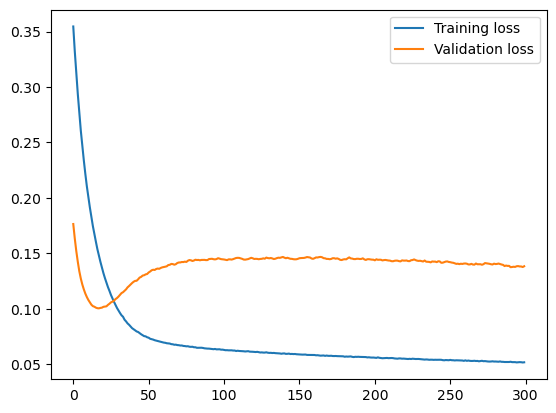

In [110]:
# model archetechture
model = keras.models.Sequential(name='RNN')
model.add(keras.layers.SimpleRNN(16, return_sequences = True, activation='sigmoid', input_shape=[None,11]))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(nobs)))
optimizer = tf.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer,
                loss='mse',
                metrics=['mean_squared_error'])
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor="mean_squared_error", patience=10)]
history = model.fit(X_train_norm, Y_train_norm, epochs=300,
            validation_data=(X_valid_norm, Y_valid_norm), 
            callbacks=callbacks_list
            )
_, accuracy = model.evaluate(X_test, Y_test)


plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

1/1 [==============================] - 0s 55ms/step
MSE: 126291.3957112862


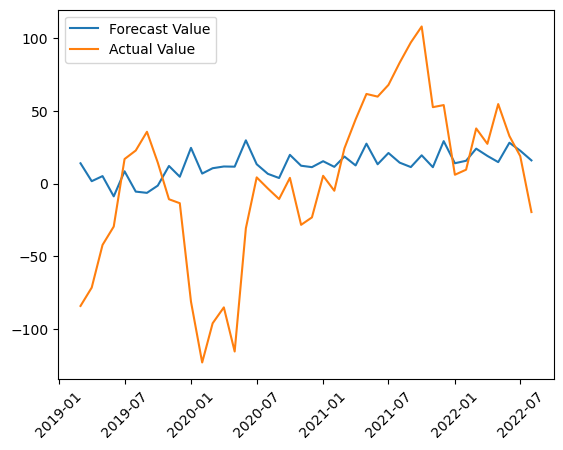

In [111]:
# Normalize test set
X_test_norm = (X_test - X_min)/(X_max - X_min)
# Predict
Y_pred_norm = model.predict(X_test_norm)
# Denormalize target
Y_pred = Y_pred_norm * (Y_max[0][0][0] - Y_min[0][0][0]) + Y_min[0][0][0]

Y_pred_last_step = Y_pred[:, -1, :].reshape(nobs)
Y_test_last_step = Y_test[:, -1, :].reshape(nobs)

plt.plot(test_df.index, Y_pred_last_step, label='Forecast Value')
plt.plot(test_df.index, Y_test_last_step, label='Actual Value')
plt.xticks(rotation=45)
plt.legend()

print('MSE:', np.sum((Y_pred_last_step - Y_test_last_step)**2))

### LSTM

Epoch 1/200
7/7 [==============================] - 1s 21ms/step - loss: 0.2253 - mean_squared_error: 0.2253 - val_loss: 0.0503 - val_mean_squared_error: 0.0503
Epoch 2/200
7/7 [==============================] - 0s 7ms/step - loss: 0.1393 - mean_squared_error: 0.1393 - val_loss: 0.0860 - val_mean_squared_error: 0.0860
Epoch 3/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0964 - mean_squared_error: 0.0964 - val_loss: 0.1230 - val_mean_squared_error: 0.1230
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0770 - mean_squared_error: 0.0770 - val_loss: 0.1372 - val_mean_squared_error: 0.1372
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0673 - mean_squared_error: 0.0673 - val_loss: 0.1371 - val_mean_squared_error: 0.1371
Epoch 6/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0622 - mean_squared_error: 0.0622 - val_loss: 0.1386 - val_mean_squared_error: 0.1386
Epoch 7/200
7/7 [============================

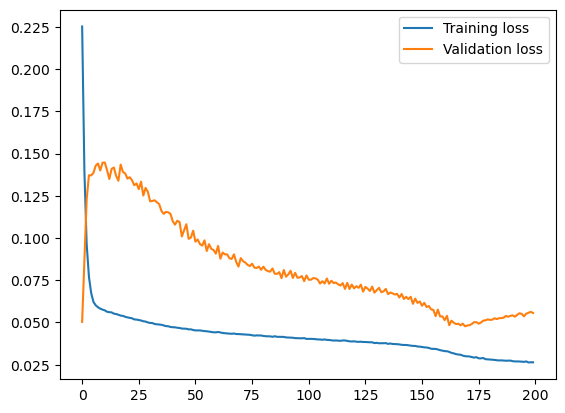

In [112]:
# model archetechture
model = keras.models.Sequential(name='LSTM')
model.add(keras.layers.LSTM(16, return_sequences = True, activation='sigmoid', input_shape=[None,11]))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(nobs)))
#model.add(keras.layers.TimeDistributed(keras.layers.Dense(d*nobs)))
optimizer = tf.optimizers.Adam(learning_rate=0.003)
model.compile(optimizer=optimizer,
                loss='mse',
                metrics=['mean_squared_error'])
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor="mean_squared_error", patience=10)]
history = model.fit(X_train_norm, Y_train_norm, epochs=200,
            validation_data=(X_valid_norm, Y_valid_norm), 
            callbacks=callbacks_list
            )
_, accuracy = model.evaluate(X_test, Y_test)


plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

1/1 [==============================] - 0s 71ms/step
MSE: 83889.83318168668


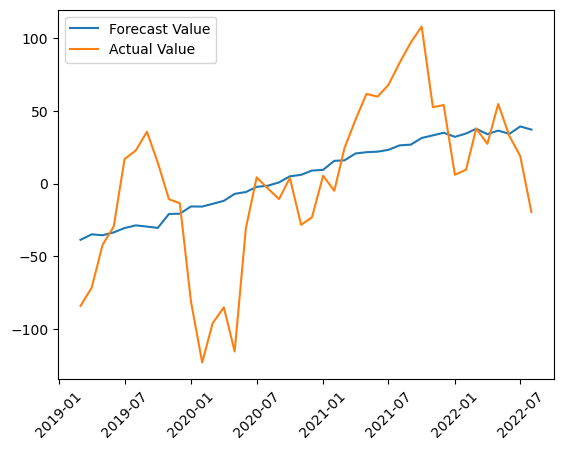

In [113]:
# Normalize test set
X_test_norm = (X_test - X_min)/(X_max - X_min)
# Predict
Y_pred_norm = model.predict(X_test_norm)
# Denormalize target
Y_pred = Y_pred_norm * (Y_max[0][0][0] - Y_min[0][0][0]) + Y_min[0][0][0]

Y_pred_last_step = Y_pred[:, -1, :].reshape(nobs)
Y_test_last_step = Y_test[:, -1, :].reshape(nobs)

plt.plot(test_df.index, Y_pred_last_step, label='Forecast Value')
plt.plot(test_df.index, Y_test_last_step, label='Actual Value')
plt.xticks(rotation=45)
plt.legend()

print('MSE:', np.sum((Y_pred_last_step - Y_test_last_step)**2))

# Ex. COVID

Try the forecasting excluding COVID19 shock in test data

In [114]:
exCOVID_df = st_df[:-33]

## Data Split

In [115]:
# n_steps --> number of lags to predict future
# nobs --> number of forecast periods
# n_valid --> validation set
# n --> total number of observations
# d --> number of features
# shape(Sample size) = (sample size, time steps, features)
n_steps = 38
nobs = 36
n_valid = 40
n = exCOVID_df.shape[0]
d = exCOVID_df.shape[1]
n_train = n - nobs - n_valid

test = exCOVID_df[-nobs-n_steps:]
valid = exCOVID_df[-n_steps-n_valid-nobs:-nobs]
train = exCOVID_df[:n_train]

# Split train set into subsequences
X_train = np.empty((n_train - n_steps - nobs, n_steps, d))
Y_train = np.empty((n_train - n_steps - nobs, n_steps, nobs))
for i in range(n_train - n_steps - nobs):
    X_train[i, :, :] = train[i : i+n_steps]
    for j in range(nobs):
        Y_train[i, :, j] = train[i+j+1 : i+j+n_steps+1].iloc[:,0]

# Split validation set into subsequences
X_valid = np.empty((n_valid - nobs, n_steps, d))
Y_valid = np.empty((n_valid - nobs, n_steps, nobs))
for i in range(n_valid - nobs):
    X_valid[i, :, :] = valid[i : i+n_steps]
    for j in range(nobs):
        Y_valid[i, :, j] = valid[i+j+1 : i+j+n_steps+1].iloc[:,0]

# Split test set into subsequences
X_test = np.array(exCOVID_df[-nobs-n_steps:-nobs])
Y_test = np.empty((n_steps, nobs))
for j in range(nobs):
    Y_test[:, j] = test[j+1 : j+n_steps+1].iloc[:,0]

X_test = X_test.reshape(1, n_steps, d)
Y_test = Y_test.reshape(1, n_steps, nobs)

# Normalization
X_min = X_train.min(axis=(0, 1), keepdims=True)
X_max = X_train.max(axis=(0, 1), keepdims=True)
X_train_norm = (X_train - X_min)/(X_max - X_min)

Y_min = Y_train.min(axis=(0, 1), keepdims=True)
Y_max = Y_train.max(axis=(0, 1), keepdims=True)
Y_train_norm = (Y_train - Y_min)/(Y_max - Y_min)

X_valid_norm = (X_valid - X_min)/(X_max - X_min)
Y_valid_norm = (Y_valid - Y_valid)/(Y_max - Y_min)

In [116]:
train_df = exCOVID_df[:-nobs]
test_df = exCOVID_df[-nobs:]

## Forecasting

### RNN

Epoch 1/300
7/7 [==============================] - 0s 18ms/step - loss: 0.3365 - mean_squared_error: 0.3365 - val_loss: 0.1422 - val_mean_squared_error: 0.1422
Epoch 2/300
7/7 [==============================] - 0s 4ms/step - loss: 0.3174 - mean_squared_error: 0.3174 - val_loss: 0.1317 - val_mean_squared_error: 0.1317
Epoch 3/300
7/7 [==============================] - 0s 4ms/step - loss: 0.2981 - mean_squared_error: 0.2981 - val_loss: 0.1226 - val_mean_squared_error: 0.1226
Epoch 4/300
7/7 [==============================] - 0s 4ms/step - loss: 0.2806 - mean_squared_error: 0.2806 - val_loss: 0.1151 - val_mean_squared_error: 0.1151
Epoch 5/300
7/7 [==============================] - 0s 4ms/step - loss: 0.2644 - mean_squared_error: 0.2644 - val_loss: 0.1092 - val_mean_squared_error: 0.1092
Epoch 6/300
7/7 [==============================] - 0s 4ms/step - loss: 0.2505 - mean_squared_error: 0.2505 - val_loss: 0.1045 - val_mean_squared_error: 0.1045
Epoch 7/300
7/7 [============================

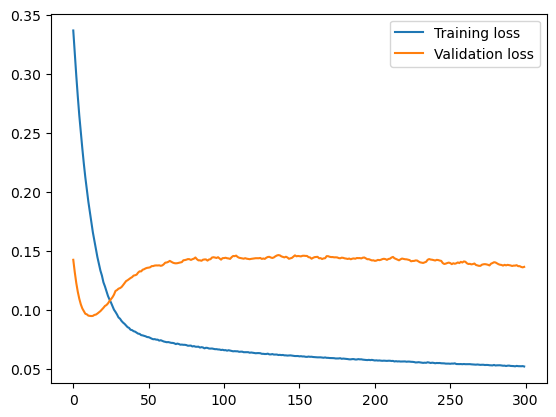

In [121]:
# model archetechture
model = keras.models.Sequential(name='RNN')
model.add(keras.layers.SimpleRNN(16, return_sequences = True, activation='sigmoid', input_shape=[None,11]))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(nobs)))
optimizer = tf.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer,
                loss='mse',
                metrics=['mean_squared_error'])
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor="mean_squared_error", patience=10)]
history = model.fit(X_train_norm, Y_train_norm, epochs=300,
            validation_data=(X_valid_norm, Y_valid_norm), 
            callbacks=callbacks_list
            )
_, accuracy = model.evaluate(X_test, Y_test)


plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

1/1 [==============================] - 0s 276ms/step
MSE: 96211.16842159884


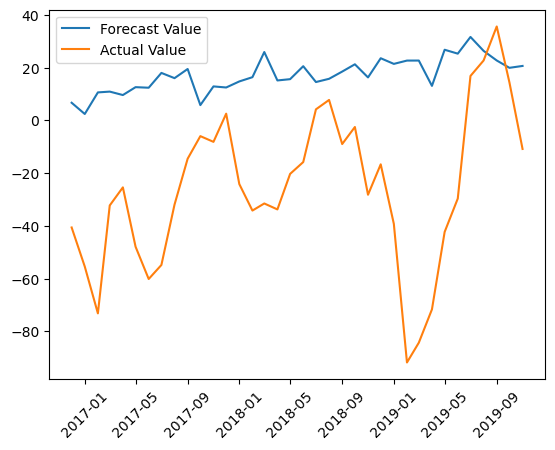

In [122]:
# Normalize test set
X_test_norm = (X_test - X_min)/(X_max - X_min)
# Predict
Y_pred_norm = model.predict(X_test_norm)
# Denormalize target
Y_pred = Y_pred_norm * (Y_max[0][0][0] - Y_min[0][0][0]) + Y_min[0][0][0]

Y_pred_last_step = Y_pred[:, -1, :].reshape(nobs)
Y_test_last_step = Y_test[:, -1, :].reshape(nobs)

plt.plot(test_df.index, Y_pred_last_step, label='Forecast Value')
plt.plot(test_df.index, Y_test_last_step, label='Actual Value')
plt.xticks(rotation=45)
plt.legend()

print('MSE:', np.sum((Y_pred_last_step - Y_test_last_step)**2))

### LSTM

Epoch 1/200
7/7 [==============================] - 1s 21ms/step - loss: 0.2412 - mean_squared_error: 0.2412 - val_loss: 0.0422 - val_mean_squared_error: 0.0422
Epoch 2/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1563 - mean_squared_error: 0.1563 - val_loss: 0.0614 - val_mean_squared_error: 0.0614
Epoch 3/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1101 - mean_squared_error: 0.1101 - val_loss: 0.1017 - val_mean_squared_error: 0.1017
Epoch 4/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0850 - mean_squared_error: 0.0850 - val_loss: 0.1329 - val_mean_squared_error: 0.1329
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0731 - mean_squared_error: 0.0731 - val_loss: 0.1441 - val_mean_squared_error: 0.1441
Epoch 6/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0661 - mean_squared_error: 0.0661 - val_loss: 0.1431 - val_mean_squared_error: 0.1431
Epoch 7/200
7/7 [============================

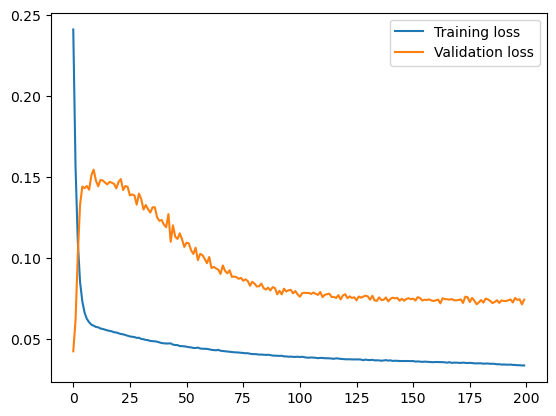

In [123]:
# model archetechture
model = keras.models.Sequential(name='LSTM')
model.add(keras.layers.LSTM(16, return_sequences = True, activation='sigmoid', input_shape=[None,11]))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(nobs)))
#model.add(keras.layers.TimeDistributed(keras.layers.Dense(d*nobs)))
optimizer = tf.optimizers.Adam(learning_rate=0.003)
model.compile(optimizer=optimizer,
                loss='mse',
                metrics=['mean_squared_error'])
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor="mean_squared_error", patience=10)]
history = model.fit(X_train_norm, Y_train_norm, epochs=200,
            validation_data=(X_valid_norm, Y_valid_norm), 
            callbacks=callbacks_list
            )
_, accuracy = model.evaluate(X_test, Y_test)


plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

1/1 [==============================] - 0s 64ms/step
MSE: 48462.16931407845


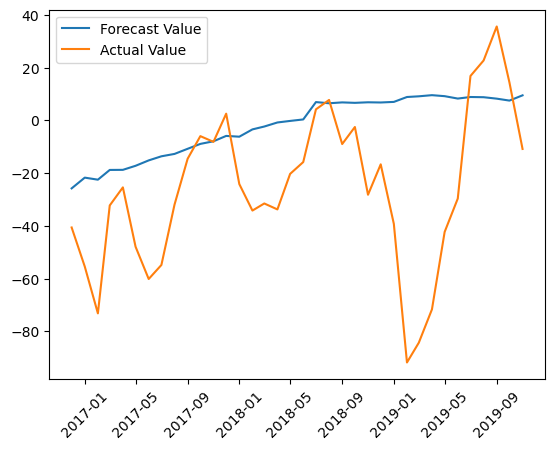

In [124]:
# Normalize test set
X_test_norm = (X_test - X_min)/(X_max - X_min)
# Predict
Y_pred_norm = model.predict(X_test_norm)
# Denormalize target
Y_pred = Y_pred_norm * (Y_max[0][0][0] - Y_min[0][0][0]) + Y_min[0][0][0]

Y_pred_last_step = Y_pred[:, -1, :].reshape(nobs)
Y_test_last_step = Y_test[:, -1, :].reshape(nobs)

plt.plot(test_df.index, Y_pred_last_step, label='Forecast Value')
plt.plot(test_df.index, Y_test_last_step, label='Actual Value')
plt.xticks(rotation=45)
plt.legend()

print('MSE:', np.sum((Y_pred_last_step - Y_test_last_step)**2))